# 필요한 모듈 정의 밑 다운로드 + 데이터셋 다운로드

In [1]:
!pip install roboflow
!pip install keras_cv
!pip install xmltodict

from roboflow import Roboflow
rf = Roboflow(api_key="CWROiBllXAfAbcRUp2iV")
project = rf.workspace("joseph-nelson").project("hard-hat-workers")
dataset = project.version(2).download("voc")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78
  Attempting uninstall: idna
    Found existing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.5 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Hard-Hat-Workers-2 in voc:: 100%|██████████| 14072/14072 [00:02<00:00, 6189.31it/s]


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import xmltodict
from tqdm import tqdm
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.image import draw_bounding_boxes

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# CONFIG

In [3]:
CONFIG = {
    "Weight_decay" : 0.0005,
    "momentum" : 0.9,
    "batch_size" : 16,
    "epoch" : 10,
    "learning_rate" : 0.001,
    "image_size" : (400, 400),
    "val_size" : 0.2
}

# 로드받은 데이터 확인해보기

In [4]:
train_path = "/content/Hard-Hat-Workers-2/train"
test_path = "/content/Hard-Hat-Workers-2/test"

train_image_path_list = sorted(glob(train_path + "/*.jpg"))
train_annotations_path_list = sorted(glob(train_path + "/*.xml"))

test_image_path_list = sorted(glob(test_path + "/*.jpg"))
test_annotations_path_list = sorted(glob(test_path + "/*.xml"))
print(f"train_length : {len(train_image_path_list)}, train_xml : {train_annotations_path_list[0]}")
print(f"test_length : {len(test_image_path_list)}, test_xml : {test_annotations_path_list[0]}")

train_length : 5269, train_xml : /content/Hard-Hat-Workers-2/train/000001_jpg.rf.fddb09e33a544e332617f8ceb53ee805.xml
test_length : 1766, test_xml : /content/Hard-Hat-Workers-2/test/005298_jpg.rf.647d148af5d961d8bbc041f172247170.xml


In [5]:
def get_Classes_inImage(xml_file_list): # XML을 DICT형식으로 받아와서 클래스 갯수 세는 함수
    Classes_inDataSet = []

    for xml_file_path in xml_file_list:

        f = open(xml_file_path)
        xml_file = xmltodict.parse(f.read())
        # 사진에 객체가 여러개 있을 경우
        try:
            for obj in xml_file['annotation']['object']:
                Classes_inDataSet.append(obj['name'].lower()) # 들어있는 객체 종류를 알아낸다
        # 사진에 객체가 하나만 있을 경우
        except TypeError as e:
            Classes_inDataSet.append(xml_file['annotation']['object']['name'].lower())
        f.close()

    Classes_inDataSet = list(set(Classes_inDataSet))
    Classes_inDataSet.sort() # 알파벳 순으로 정렬

    return Classes_inDataSet

ALL_CLASS_LIST = get_Classes_inImage(train_annotations_path_list)
print(f"총 CLASS 목록 : {ALL_CLASS_LIST}")

총 CLASS 목록 : ['head', 'helmet', 'person']


In [83]:
def get_label_from_XML(path):
  f = open(path)
  xml_file = xmltodict.parse(f.read())['annotation']
  f.close()
  class_cnt = len(ALL_CLASS_LIST)
  resized_width = float(CONFIG['image_size'][1])
  resized_height = float(CONFIG['image_size'][0])

  image_width = float(xml_file['size']['width'])
  image_height = float(xml_file['size']['height'])
  label = np.zeros((7, 7, len(ALL_CLASS_LIST) + 5))

  try:
    for obj in xml_file['object']:
      class_num = ALL_CLASS_LIST.index(obj['name'].lower())

      xmin = float(float(obj['bndbox']['xmin']) * (resized_width / image_width))
      xmax = float(float(obj['bndbox']['xmax']) * (resized_width / image_width))
      ymin = float(float(obj['bndbox']['ymin']) * (resized_height / image_height))
      ymax = float(float(obj['bndbox']['ymax']) * (resized_height / image_height))

      x_center = (xmax + xmin) / 2.0
      y_center = (ymax + ymin) / 2.0
      width = (xmax - xmin)
      height = (ymax - ymin)

      y_district = np.floor(((y_center / resized_height) * 7.0)).astype('int')
      x_district = np.floor(((x_center / resized_width) * 7.0)).astype('int')
      y_val_in_cell = float((y_center - y_district * resized_height / 7.0) / (resized_height / 7.0))
      x_val_in_cell = float((x_center - x_district * resized_width / 7.0) / (resized_width / 7.0))
      width /= resized_width
      height /= resized_height

      label[y_district][x_district][class_num] = 1.0
      label[y_district][x_district][len(ALL_CLASS_LIST):len(ALL_CLASS_LIST)+4] = [x_val_in_cell, y_val_in_cell, width, height]
      label[y_district][x_district][-1] = 1.0
  except TypeError as e:
      class_num = ALL_CLASS_LIST.index(xml_file['object']['name'].lower())

      xmin = float(float(xml_file['object']['bndbox']['xmin']) * (resized_width / image_width))
      xmax = float(float(xml_file['object']['bndbox']['xmax']) * (resized_width / image_width))
      ymin = float(float(xml_file['object']['bndbox']['ymin']) * (resized_height / image_height))
      ymax = float(float(xml_file['object']['bndbox']['ymax']) * (resized_height / image_height))

      x_center = (xmax + xmin) / 2.0
      y_center = (ymax + ymin) / 2.0
      width = (xmax - xmin)
      height = (ymax - ymin)

      y_district = np.floor(((y_center / resized_height) * 7.0)).astype('int')
      x_district = np.floor(((x_center / resized_width) * 7.0)).astype('int')
      y_val_in_cell = float((y_center - y_district * resized_height / 7.0) / (resized_height / 7.0))
      x_val_in_cell = float((x_center - x_district * resized_width / 7.0) / (resized_width / 7.0))
      width /= resized_width
      height /= resized_height

      label[y_district][x_district][class_num] = 1.0
      label[y_district][x_district][len(ALL_CLASS_LIST):len(ALL_CLASS_LIST)+4] = [x_val_in_cell, y_val_in_cell, width, height]
      label[y_district][x_district][-1] = 1.0

  return label

[array([0.193     , 0.74474474, 0.106     , 0.17417417]), array([0.268     , 0.27027027, 0.08      , 0.14414414])]


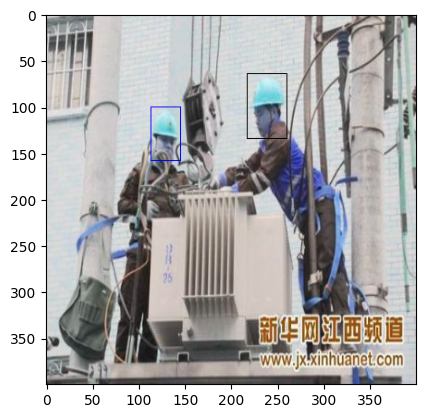

tf.Tensor(
[[0.16216215 0.546      0.33633634 0.652     ]
 [0.25225225 0.284      0.3963964  0.364     ]], shape=(2, 4), dtype=float32)


In [87]:
def decode_bboxes(box, img_size, loc):
  resized_width = float(CONFIG['image_size'][1])
  resized_height = float(CONFIG['image_size'][0])
  img_h, img_w = img_size
  # box *= [img_w, img_h, img_w, img_h]

  x, y, w, h = box
  x = x  / 7.0 + float(loc[1]) / 7.0
  y = y  / 7.0 + float(loc[0]) / 7.0
  xmin = x - w / 2.0
  xmax = x + w / 2.0
  ymin = y - h / 2.0
  ymax = y + h / 2.0

  return np.array([ymin, xmin, ymax, xmax])

def load_img(path):
  img = cv2.imread(train_image_path_list[1]) / 255.
  img = cv2.resize(img, CONFIG['image_size'])
  return img

def draw_bboxes(img_tensor, boxes_tensor):
  colors = np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

  if len(img_tensor.shape) != 4:
    img_tensor = tf.expand_dims(img_tensor, axis=0)
  if len(boxes_tensor.shape) != 3:
    boxes_tensor = tf.expand_dims(boxes_tensor, axis=0)

  image_with_box = draw_bounding_boxes(img_tensor, boxes_tensor, colors)
  plt.imshow(image_with_box.numpy()[0], cmap = 'gray')
  # plt.imshow(img_tensor.numpy()[0])
  plt.show()


label = get_label_from_XML(train_annotations_path_list[1])
img = load_img(train_image_path_list[1])
boxes = []
locs = []

for i in range(7):
  for j in range(7):
    if label[i][j][-1] < 0.5:
      continue
    boxes.append(label[i][j][-5:-1])
    locs.append((i, j))
print(boxes)
for box, loc in zip(boxes, locs):
  temp = decode_bboxes(box, img.shape[:-1], loc)
  for i in range(4):
    box[i] = temp[i]

img = tf.convert_to_tensor(img, dtype=tf.float32)
boxes = tf.convert_to_tensor(boxes, dtype=tf.float32)
draw_bboxes(img, boxes)
print(boxes)

# 데이터셋 만들기

In [88]:
image_paths = []
labels = []

for img_file, xml_file in tqdm(zip(train_image_path_list, train_annotations_path_list)):
    label = get_label_from_XML(xml_file)
    image_paths.append(img_file)
    labels.append(label)

5269it [00:02, 2244.43it/s]


In [90]:
labels = tf.constant(labels)
image_paths = tf.ragged.constant(image_paths)
data = tf.data.Dataset.from_tensor_slices((image_paths, labels))

(5269, 7, 7, 8)


In [91]:
# Determine the number of validation samples
num_val = int(len(train_annotations_path_list) * CONFIG['val_size'])

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [92]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, CONFIG['image_size']) /255.
    return image


def load_dataset(image_path, label):
    # Read Image
    image = load_image(image_path)
    return image, label

In [93]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(CONFIG['batch_size'] * 4)
train_ds = train_ds.batch(CONFIG['batch_size'], drop_remainder=True)

In [94]:
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(CONFIG['batch_size'] * 4)
val_ds = val_ds.batch(CONFIG['batch_size'], drop_remainder=True)

In [95]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# YOLO 모델 구성

In [96]:
class YOLO(keras.Model):
    def __init__(self, activation):
        super().__init__()
        self.conv_1 = layers.Conv2D(64, 7, strides=2, padding='same', activation=activation)
        self.pooling = layers.MaxPooling2D(pool_size=(2, 2), strides=2)

        self.conv_2 = layers.Conv2D(192, 3, strides=1, padding='same', activation=activation)

        self.conv_3 = layers.Conv2D(128, 1, strides=1, padding='same', activation=activation)
        self.conv_3_1 = layers.Conv2D(256, 3, strides=1, padding='same', activation=activation)
        self.conv_3_2 = layers.Conv2D(256, 1, strides=1, padding='same', activation=activation)
        self.conv_3_3 = layers.Conv2D(512, 3, strides=1, padding='same', activation=activation)

        self.conv_4 = layers.Conv2D(256, 1, strides=1, padding='same', activation=activation)
        self.conv_4_1 = layers.Conv2D(512, 3, strides=1, padding='same', activation=activation)
        self.conv_4_2 = layers.Conv2D(256, 1, strides=1, padding='same', activation=activation)
        self.conv_4_3 = layers.Conv2D(512, 3, strides=1, padding='same', activation=activation)
        self.conv_4_4 = layers.Conv2D(256, 1, strides=1, padding='same', activation=activation)
        self.conv_4_5 = layers.Conv2D(512, 3, strides=1, padding='same', activation=activation)
        self.conv_4_6 = layers.Conv2D(256, 1, strides=1, padding='same', activation=activation)
        self.conv_4_7 = layers.Conv2D(512, 3, strides=1, padding='same', activation=activation)
        self.conv_4_8 = layers.Conv2D(512, 1, strides=1, padding='same', activation=activation)
        self.conv_4_9 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)

        self.conv_5 = layers.Conv2D(512, 1, strides=1, padding='same', activation=activation)
        self.conv_5_1 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)
        self.conv_5_2 = layers.Conv2D(512, 1, strides=1, padding='same', activation=activation)
        self.conv_5_3 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)
        self.conv_5_4 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)
        self.conv_5_5 = layers.Conv2D(1024, 3, strides=2, padding='same', activation=activation)

        self.conv_6 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)
        self.conv_6_1 = layers.Conv2D(1024, 3, strides=1, padding='same', activation=activation)

        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(units = 4096, activation=activation)
        self.dense_2 = layers.Dense(units = 1470, activation=None)
        self.dropout = layers.Dropout(0.5)
        self.output_layer = layers.Reshape((7, 7, 30))

    def call(self, inputs):
        block_1 = self.conv_1(inputs)
        block_1 = self.pooling(block_1)

        block_2 = self.conv_2(block_1)
        block_2 = self.pooling(block_2)

        block_3 = self.conv_3(block_2)
        block_3 = self.conv_3_1(block_3)
        block_3 = self.conv_3_2(block_3)
        block_3 = self.conv_3_3(block_3)
        block_3 = self.pooling(block_3)

        block_4 = self.conv_4(block_3)
        block_4 = self.conv_4_1(block_4)
        block_4 = self.conv_4_2(block_4)
        block_4 = self.conv_4_3(block_4)
        block_4 = self.conv_4_4(block_4)
        block_4 = self.conv_4_5(block_4)
        block_4 = self.conv_4_6(block_4)
        block_4 = self.conv_4_7(block_4)
        block_4 = self.conv_4_8(block_4)
        block_4 = self.conv_4_9(block_4)
        block_4 = self.pooling(block_4)

        block_5 = self.conv_5(block_4)
        block_5 = self.conv_5_1(block_5)
        block_5 = self.conv_5_2(block_5)
        block_5 = self.conv_5_3(block_5)
        block_5 = self.conv_5_4(block_5)
        block_5 = self.conv_5_5(block_5)

        block_6 = self.conv_6(block_5)
        block_6 = self.conv_6_1(block_6)

        outputs = self.flatten(block_6)
        outputs = self.dense_1(outputs)
        outputs = self.dense_2(outputs)
        outputs = self.dropout(outputs)
        outputs = self.output_layer(outputs)
        return outputs

# Multitask loss 구현하기

In [69]:
ALL_CLASS = len(ALL_CLASS_LIST)


def compute_iou(tensor_1, tensor_2):
  # tensor_1, tensor_2 : shape (4,) tensor [x, y, w, h]
  # output : iou of two tensor
  x11 = tensor_1[0] - tensor_1[2] / 2
  y11 = tensor_1[1] - tensor_1[3] / 2
  x12 = tensor_1[0] + tensor_1[2] / 2
  y12 = tensor_1[1] + tensor_1[3] / 2

  x21 = tensor_2[0] - tensor_2[2] /2
  y21 = tensor_2[1] - tensor_2[3] /2
  x22 = tensor_2[0] + tensor_2[2] /2
  y22 = tensor_2[1] + tensor_2[3] /2

  inter_x1 = tf.maximum(x11, x21)
  inter_y1 = tf.maximum(y11, y21)
  inter_x2 = tf.minimum(x12, x22)
  inter_y2 = tf.minimum(y12, y22)
  inter_area = tf.maximum(inter_x2 - inter_x1, 1e-6) * tf.maximum(inter_y2 - inter_y1, 1e-6)
  bboxes1_area = (x12 - x11) * (y12 - y11)
  bboxes2_area = (x22 - x21) * (y22 - y21)
  return inter_area / ((bboxes1_area + bboxes2_area - inter_area) + 1e-6)


class MultiTaskLoss(keras.losses.Loss):
  def __init__(self, coord, noobj):
    super().__init__()
    self.coord = coord
    self.noobj = noobj

  # y_pred(batch, 7, 7, ALL_CLASS + 10), y_true (batch, 7, 7, ALL_CLASS + 5)
  def call(self, y_true, y_pred):
    batch_loss = tf.Variable(0.0)
    count = tf.Variable(float(len(y_true)))

    for batch in range(len(y_true)):
      for i in range(7):
        for j in range(7):
          if y_true[batch][i][j][-1] < 0.5:
            batch_loss += self.noobj * (y_pred[batch][i][j][-1] ** 2)
            batch_loss += self.noobj * (y_pred[batch][i][j][-6] ** 2)
            continue

          true_box = y_true[-5:-1]
          box_1 = y_pred[-5:-1]
          box_2 = y_pred[-10:-6]
          iou_1 = compute_iou(true_box, box_1)
          iou_2 = compute_iou(true_box, box_2)

          if iou_1 > iou_2:
            batch_loss += self.coord * ((box_1[0] - true_box[0]) ** 2 + (box_1[1] - true_box[1]))
            batch_loss += self.coord * ((tf.math.sqrt(box_1[2]) - ))

# Train

In [70]:
model = YOLO("relu")
losses = MultiTaskLoss(5.0, 1.0)
model.compile(optimizer="rmsprop", loss=losses)

In [71]:
model.fit(train_ds, epochs=2, validation_data=val_ds)

Epoch 1/2


ValueError: ignored